In [1]:
import json
import requests
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = True
import pandas as pd
import seaborn as sns 
import itertools
import time
from oaipmh.client import Client
from oaipmh.metadata import MetadataRegistry, oai_dc_reader

In [2]:
max_dataset = 500
fuji_service = 'http://localhost:1071/fuji/api/v1/evaluate'
data_dir = 'results'

Request metric defs

In [3]:
metrics = []
try:
    request = requests.get('http://localhost:1071/fuji/api/v1/metrics',headers={'Content-Type': 'application/json'}, auth=('username', 'password'))
    mm = request.json()['metrics']
    for m in mm:
        metrics.append({k: m[k] for k in ('metric_identifier', 'metric_name', 'total_score')})
except requests.exceptions.RequestException as e:
    print(e)
except requests.exceptions.ConnectionError as e1:
    print(e1)

In [4]:
df_metrics = pd.DataFrame.from_dict(metrics)
df_metrics

,metric_identifier,metric_name,total_score
0,FsF-F1-01D,Data is assigned a globally unique identifier.,1
1,FsF-F1-02D,Data is assigned a persistent identifier.,1
2,FsF-F2-01M,Metadata includes descriptive core elements (c...,2
3,FsF-F3-01M,Metadata includes the identifier of the data i...,1
4,FsF-F4-01M,Metadata is offered in such a way that it can ...,2
5,FsF-A1-01M,Metadata contains access level and access cond...,1
6,FsF-A1-02MD,Metadata as well as data are retrievable by th...,2
7,FsF-A2-01M,"Metadata remains available, even if the data i...",1
8,FsF-I1-01M,Metadata is represented using a formal knowled...,2
9,FsF-I1-02M,Metadata uses semantic resources,1


Request dataverseno records

In [5]:
datasets = []
oai_dataverno = 'https://dataverse.no/oai'
#https://dataverse.no/oai?verb=ListRecords&metadataPrefix=oai_dc&set=earth_and_environmental

In [6]:
registry = MetadataRegistry()
registry.registerReader('oai_dc', oai_dc_reader)
client = Client(oai_dataverno, registry)
for record in client.listRecords(metadataPrefix='oai_dc', set='earth_and_environmental'):
    if record[1].getMap():
        datasets.append(record[1].getMap().get('identifier')[0])

In [7]:
len(datasets)

606

In [8]:
datasets[:5]

['https://doi.org/10.18710/0ANF8U',
 'https://doi.org/10.18710/0NGBMI',
 'https://doi.org/10.18710/0NHUJG',
 'https://doi.org/10.18710/0VUUNO',
 'https://doi.org/10.18710/0WGHZM']

In [9]:
import random
datasets = random.choices(datasets, k = max_dataset)

In [10]:
print('Total datasets :', len(datasets))

Total datasets : 500


In [11]:
datasets[:5]

['https://doi.org/10.18710/DWYBP9',
 'https://doi.org/10.18710/SSTE5H',
 'https://doi.org/10.18710/9SEELW',
 'https://doi.org/10.18710/SOABOK',
 'https://doi.org/10.18710/CXRCUW']

In [12]:
timestr = time.strftime("%Y%m%d")
timestr

'20200906'

In [13]:
%%time 
i=0
all_records = []
if len(datasets) == max_dataset:
    for d in datasets:
        i += 1
        print(i)
        req = {'object_identifier':d, 'test_debug':True, 'oaipmh_endpoint':oai_dataverno}
        r = requests.post(fuji_service, data=json.dumps(req), headers={'Content-Type': 'application/json'}, auth=('username', 'password'))
        json_data = r.json()
        records = {}
        records['identifier'] = d
        records['result'] = json_data
        all_records.append(records)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [14]:
file_name = data_dir+'/'+'dataverseno_'+timestr+'.json'
with open(file_name, 'w') as f:
    json.dump(all_records, f)

In [15]:
with open(file_name) as json_file:
    data = json.load(json_file)

In [16]:
def get_assessment_result(id):
    jsn = None
    for data_dict in data:
        if data_dict['identifier'] == id:
            jsn = data_dict['result']
    return jsn

In [17]:
test_dataset ='https://doi.org/10.18710/S4JGV7'

In [18]:
get_assessment_result(test_dataset)

In [19]:
final = []
for data_dict in data:
    results = {}
    results['identifier'] = data_dict['identifier']
    dd = data_dict['result'] # list of dict
    #print(results['identifier'])
    for d in dd:
        metric_identifier = d['metric_identifier']
        sub_principle = metric_identifier.split('-')[1]
        principle = sub_principle[0]+'_earned'
        principle_total = sub_principle[0]+'_total'
        if not sub_principle in results:
            results[sub_principle] = d['score']['earned']
        else:
            results[sub_principle] += d['score']['earned']
        if not principle in results:
            results[principle] = d['score']['earned']
        else:
            results[principle] += d['score']['earned']
        if not principle_total in results:
            results[principle_total] = d['score']['total']
        else:
            results[principle_total] += d['score']['total']
    final.append(results)

In [20]:
df_results = pd.DataFrame.from_dict(final)

In [21]:
cols = ['identifier','F1','F2','F3','F4','A1','A1','I1','I3','R1','R1.1','R1.2','R1.3','F_earned','F_total','A_earned','A_total','I_earned','I_total','R_earned','R_total']
df_results = df_results[cols]

In [22]:
df_results.head()

,identifier,F1,F2,F3,F4,A1,A1,I1,I3,R1,...,R1.2,R1.3,F_earned,F_total,A_earned,A_total,I_earned,I_total,R_earned,R_total
0,https://doi.org/10.18710/DWYBP9,2,2,1,2,0,0,2,0,3,...,1,2,7,7,0,1,2,4,7,9
1,https://doi.org/10.18710/SSTE5H,2,2,1,2,0,0,2,1,3,...,1,2,7,7,0,1,3,4,7,9
2,https://doi.org/10.18710/9SEELW,2,2,1,2,0,0,2,1,3,...,1,2,7,7,0,1,3,4,7,9
3,https://doi.org/10.18710/SOABOK,2,2,1,2,0,0,2,1,3,...,1,2,7,7,0,1,3,4,7,9
4,https://doi.org/10.18710/CXRCUW,2,2,1,2,0,0,2,1,3,...,1,2,7,7,0,1,3,4,7,9


In [23]:
df_results ['F_Principle'] = (df_results ['F_earned'] / df_results ['F_total'] ).round(2)
df_results ['A_Principle'] = (df_results ['A_earned'] / df_results ['A_total'] ).round(2)
df_results ['I_Principle'] = (df_results ['I_earned'] / df_results ['I_total'] ).round(2)
df_results ['R_Principle' ]= (df_results ['R_earned'] / df_results ['R_total']).round(2)

In [24]:
df_results.head()

,identifier,F1,F2,F3,F4,A1,A1,I1,I3,R1,...,A_earned,A_total,I_earned,I_total,R_earned,R_total,F_Principle,A_Principle,I_Principle,R_Principle
0,https://doi.org/10.18710/DWYBP9,2,2,1,2,0,0,2,0,3,...,0,1,2,4,7,9,1.0,0.0,0.50,0.78
1,https://doi.org/10.18710/SSTE5H,2,2,1,2,0,0,2,1,3,...,0,1,3,4,7,9,1.0,0.0,0.75,0.78
2,https://doi.org/10.18710/9SEELW,2,2,1,2,0,0,2,1,3,...,0,1,3,4,7,9,1.0,0.0,0.75,0.78
3,https://doi.org/10.18710/SOABOK,2,2,1,2,0,0,2,1,3,...,0,1,3,4,7,9,1.0,0.0,0.75,0.78
4,https://doi.org/10.18710/CXRCUW,2,2,1,2,0,0,2,1,3,...,0,1,3,4,7,9,1.0,0.0,0.75,0.78


In [25]:
df_hist = df_results[['identifier','F_Principle','A_Principle','I_Principle','R_Principle']]
df_hist

,identifier,F_Principle,A_Principle,I_Principle,R_Principle
0,https://doi.org/10.18710/DWYBP9,1.0,0.0,0.50,0.78
1,https://doi.org/10.18710/SSTE5H,1.0,0.0,0.75,0.78
2,https://doi.org/10.18710/9SEELW,1.0,0.0,0.75,0.78
3,https://doi.org/10.18710/SOABOK,1.0,0.0,0.75,0.78
4,https://doi.org/10.18710/CXRCUW,1.0,0.0,0.75,0.78
...,...,...,...,...,...
495,https://doi.org/10.18710/BUDBMI,1.0,0.0,0.75,0.78
496,https://doi.org/10.18710/QCQJXX,1.0,0.0,0.75,0.78
497,https://doi.org/10.18710/ETMLMH,1.0,0.0,0.50,0.78
498,https://doi.org/10.18710/FO3W0F,1.0,0.0,0.75,0.78


In [26]:
df_hist[df_hist.F_Principle <50].iloc[0]

identifier     https://doi.org/10.18710/DWYBP9
F_Principle                                  1
A_Principle                                  0
I_Principle                                0.5
R_Principle                               0.78
Name: 0, dtype: object

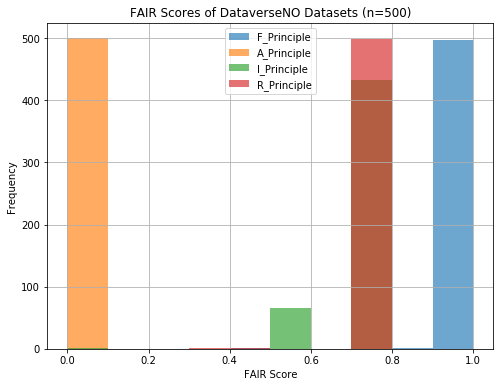

In [27]:
title = "FAIR Scores of DataverseNO Datasets (n="+str(len(df_hist))+")"
df_hist.plot.hist(sharex=True,sharey=True,alpha=0.65,figsize = (8,6), title=title)
plt.xlabel('FAIR Score')
fig_name = data_dir+'/'+'dataverseno_'+timestr+'.png'
plt.savefig(fig_name)

In [69]:
def histograms_plot(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(8,8))
    # set palette 
    palette = itertools.cycle(sns.color_palette())
    for i, feature in enumerate(features):
        c = next(palette)
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].plot.hist(bins=20, ax=ax, color=c, range=(0, 1.0))
        ax.set_title("FAIR Score - "+feature+ ' (n=' + str(len(df_hist))+')')
        ax.set(xlabel="Score", ylabel="Frequency")
    fig.subplots_adjust(top=1.4)
    plt.show()
    fig_name = data_dir+'/'+'sub_dataverseno_'+timestr+'.png'
    plt.savefig(fig_name)

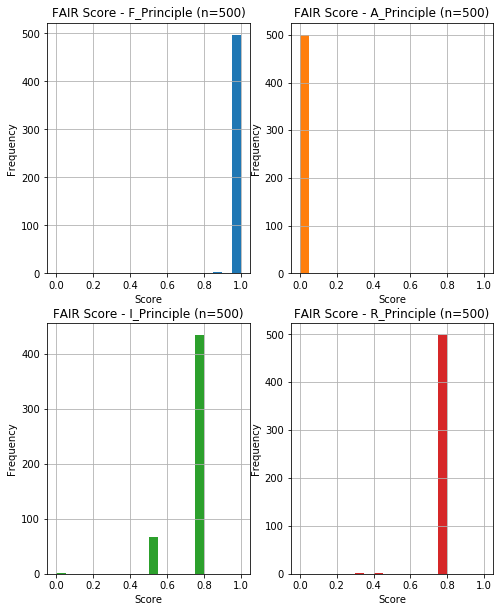

<Figure size 432x288 with 0 Axes>

In [70]:
histograms_plot(df_hist,df_hist.columns[1:],2,2)

In [71]:
pd.set_option('display.max_colwidth', None)

Findability

In [76]:
df_hist[df_hist.F_Principle < 0.9]

,identifier,F_Principle,A_Principle,I_Principle,R_Principle
35,https://doi.org/10.18710/VGQYLQ,0.86,0.0,0.75,0.44
97,https://doi.org/10.18710/XEDKEK,0.43,0.0,0.00,0.33
370,https://doi.org/10.18710/ELRRMR,0.86,0.0,0.50,0.78


In [77]:
df_hist[df_hist.F_Principle >= 0.9].head()

,identifier,F_Principle,A_Principle,I_Principle,R_Principle
0,https://doi.org/10.18710/DWYBP9,1.0,0.0,0.50,0.78
1,https://doi.org/10.18710/SSTE5H,1.0,0.0,0.75,0.78
2,https://doi.org/10.18710/9SEELW,1.0,0.0,0.75,0.78
3,https://doi.org/10.18710/SOABOK,1.0,0.0,0.75,0.78
4,https://doi.org/10.18710/CXRCUW,1.0,0.0,0.75,0.78


Accessibility

In [74]:
df_hist[df_hist.A_Principle < 0.6].head()

,identifier,F_Principle,A_Principle,I_Principle,R_Principle
0,https://doi.org/10.18710/DWYBP9,1.0,0.0,0.50,0.78
1,https://doi.org/10.18710/SSTE5H,1.0,0.0,0.75,0.78
2,https://doi.org/10.18710/9SEELW,1.0,0.0,0.75,0.78
3,https://doi.org/10.18710/SOABOK,1.0,0.0,0.75,0.78
4,https://doi.org/10.18710/CXRCUW,1.0,0.0,0.75,0.78


Interoperability

In [75]:
df_hist[df_hist.I_Principle < 0.6].head()

,identifier,F_Principle,A_Principle,I_Principle,R_Principle
0,https://doi.org/10.18710/DWYBP9,1.0,0.0,0.5,0.78
25,https://doi.org/10.18710/YDIE5W,1.0,0.0,0.5,0.78
30,https://doi.org/10.18710/0VUUNO,1.0,0.0,0.5,0.78
61,https://doi.org/10.18710/FDOXMA,1.0,0.0,0.5,0.78
67,https://doi.org/10.18710/4LABGF,1.0,0.0,0.5,0.78


In [78]:
df_hist[df_hist.I_Principle > 0.6].head()

,identifier,F_Principle,A_Principle,I_Principle,R_Principle
1,https://doi.org/10.18710/SSTE5H,1.0,0.0,0.75,0.78
2,https://doi.org/10.18710/9SEELW,1.0,0.0,0.75,0.78
3,https://doi.org/10.18710/SOABOK,1.0,0.0,0.75,0.78
4,https://doi.org/10.18710/CXRCUW,1.0,0.0,0.75,0.78
5,https://doi.org/10.18710/LBX6LT,1.0,0.0,0.75,0.78


Reusability

In [80]:
df_hist[df_hist.R_Principle < 0.4].head()

,identifier,F_Principle,A_Principle,I_Principle,R_Principle
97,https://doi.org/10.18710/XEDKEK,0.43,0.0,0.0,0.33


In [79]:
df_hist[df_hist.R_Principle > 0.6].head()

,identifier,F_Principle,A_Principle,I_Principle,R_Principle
0,https://doi.org/10.18710/DWYBP9,1.0,0.0,0.50,0.78
1,https://doi.org/10.18710/SSTE5H,1.0,0.0,0.75,0.78
2,https://doi.org/10.18710/9SEELW,1.0,0.0,0.75,0.78
3,https://doi.org/10.18710/SOABOK,1.0,0.0,0.75,0.78
4,https://doi.org/10.18710/CXRCUW,1.0,0.0,0.75,0.78


In [88]:
df_hist[df_hist.R_Principle < 0.6]

,identifier,F_Principle,A_Principle,I_Principle,R_Principle
35,https://doi.org/10.18710/VGQYLQ,0.86,0.0,0.75,0.44
97,https://doi.org/10.18710/XEDKEK,0.43,0.0,0.00,0.33
